In [1]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk import pos_tag, pos_tag_sents
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [4]:
file = pd.read_csv('Campaign Type.csv', sep='|')
file = file.loc[:,['Campaign','Product Type','Subject Line','Sent','Unique Open','Unique Click']]
file.columns = ['campaign', 'prod_type', 'subject', 'sent', 'uniq_open', 'uniq_click']
file['openrate%'] = 100*(file['uniq_open'] / file['sent'])

In [6]:
# feature engineering
F = file.copy()
F = F.drop(['sent','uniq_open','uniq_click'], axis = 1)
F.loc[:, 'word_count'] = F.apply(lambda x: len(x['subject'].split(',')), axis = 1)
F.loc[:, 'char_len'] = F.apply(lambda x: len(x['subject']), axis = 1)
F.loc[:, 'avg_word_len'] = F['char_len'] / F['word_count']
F.loc[:, 'mentioned_amt'] = F.apply(lambda x: len(re.findall("Rs\d+", x['subject'])), axis = 1)
F.loc[:, 'mentioned_Indus'] = F.apply(lambda x: len(re.findall("indus*", x['subject'].lower())), axis = 1)

# no. of nouns and no. of verbs as features
def count_pos(df, pos):
    nouns = ['NN','NNS','NNP','NNPS']
    verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
    adverbs = ['RB','RBR','RBS']
    adjectives = ['JJ','JJR','JJS']
    
    d = dict(pos_tag(df['subject'].split(','))) #already tokenized in 'subject'
    pos_values = list(d.values())
    cnt = 0

    if pos == 'noun':
        for each in pos_values:
            if each in nouns:
                cnt += 1
    elif pos == 'verb':
        for each in pos_values:
            if each in verbs:
                cnt += 1
    elif pos == 'adv':
        for each in pos_values:
            if each in adverbs:
                cnt += 1
    elif pos == 'adj':
        for each in pos_values:
            if each in adjectives:
                cnt += 1
    else:
        print('Error: pos type not specified!!')
    return cnt

F.loc[:, 'nouns'] = F.apply(lambda x: count_pos(x, pos='noun'), axis = 1)
F.loc[:, 'verbs'] = F.apply(lambda x: count_pos(x, pos='verb'), axis = 1)
F.loc[:, 'adverbs'] = F.apply(lambda x: count_pos(x, pos='adv'), axis = 1)
F.loc[:, 'adjectives'] = F.apply(lambda x: count_pos(x, pos='adj'), axis = 1)

In [7]:
le = LabelEncoder()
F['campaign'] = le.fit_transform(F['campaign'])
F['prod_type'] = le.fit_transform(F['prod_type'])

In [10]:
# tokenize
def get_doc(file_df):
    file = file_df[['subject']]
    taggeddoc = []
    texts = []
    for i, row in file.iterrows():
        # for tagged doc
        wordslist = []
        tagslist = []
        
        td = TaggedDocument(gensim.utils.to_unicode(str.encode(row['subject'])).split(','),[str(i)])
        taggeddoc.append(td)
    return taggeddoc

documents = get_doc(file)
print (len(documents),type(documents))

4900 <class 'list'>


In [12]:
d2v_model = Doc2Vec(documents=documents, dm = 0, alpha=0.025, size= 20, min_alpha=0.025, min_count=0)

# start training
for epoch in range(200):
    if epoch % 20 == 0:
        print ('Now training epoch %s'%epoch)
    d2v_model.train(documents, total_examples = len(documents), epochs=1)
    d2v_model.alpha -= 0.002  # decrease the learning rate
    d2v_model.min_alpha = d2v_model.alpha  # fix the learning rate, no decay

Now training epoch 0
Now training epoch 20
Now training epoch 40
Now training epoch 60
Now training epoch 80
Now training epoch 100
Now training epoch 120
Now training epoch 140
Now training epoch 160
Now training epoch 180


In [15]:
Q1 = pd.DataFrame(d2v_model.docvecs.vectors_docs)
Q1.columns = ['s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19']
Q2 = F.drop(['campaign','subject','char_len'], axis = 1)
Q = pd.concat([Q1, Q2], axis=1)

In [17]:
# heatmap
M = F.drop(["subject","campaign", "char_len"], axis = 1) #remove pwrful_words_cnt as its same as in avg_pwrful_words
M = M.drop_duplicates()
corr = M.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,prod_type,openrate%,word_count,avg_word_len,mentioned_amt,mentioned_Indus,nouns,verbs,adverbs,adjectives
prod_type,1,0.075,-0.6,0.46,0.18,0.48,0.012,-0.65,0.19,0.079
openrate%,0.075,1,-0.085,-0.058,-0.082,-0.11,0.16,-0.17,-0.043,0.0072
word_count,-0.6,-0.085,1,-0.81,-0.055,-0.15,0.36,0.82,-0.066,0.017
avg_word_len,0.46,-0.058,-0.81,1,0.093,0.35,-0.41,-0.6,0.13,-0.015
mentioned_amt,0.18,-0.082,-0.055,0.093,1,0.22,0.069,-0.11,0.075,-0.017
mentioned_Indus,0.48,-0.11,-0.15,0.35,0.22,1,0.0098,-0.23,0.25,0.14
nouns,0.012,0.16,0.36,-0.41,0.069,0.0098,1,-0.18,-0.26,-0.13
verbs,-0.65,-0.17,0.82,-0.6,-0.11,-0.23,-0.18,1,-0.067,-0.043
adverbs,0.19,-0.043,-0.066,0.13,0.075,0.25,-0.26,-0.067,1,-0.011
adjectives,0.079,0.0072,0.017,-0.015,-0.017,0.14,-0.13,-0.043,-0.011,1


In [22]:
X = Q.drop(["openrate%"], axis = 1)
y = Q[["openrate%"]]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,random_state=42)

Training set score: 0.86
Test set score: 0.14
-------------------------


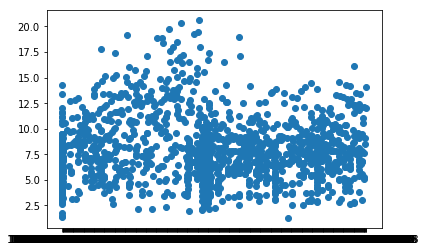

MSE: 0.015504625522538423
Explained Variance: 1.0


,feature,feature_imp
20,prod_type,0.148524
22,avg_word_len,0.067285
25,nouns,0.056171
2,s2,0.053727
16,s16,0.048625
5,s5,0.048295
9,s9,0.045582
17,s17,0.044701
7,s7,0.043799
14,s14,0.043006


In [24]:

rfr = RandomForestRegressor(n_estimators=10)

rfr.fit(X_train, Y_train)
Y_pred = rfr.predict(X_test)

print("Training set score: {:.2f}".format(rfr.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, Y_test)))
print('-'*25)

plt.scatter(Y_test, Y_pred)
plt.show()

print("MSE: {}".format(np.mean(Y_test.values - Y_pred.ravel()) ** 2))
print("Explained Variance: {}".format(rfr.score(X_test, Y_pred)))

features = Q.columns.tolist()
features.remove('openrate%')

feat_imp = pd.DataFrame({"feature" : features, "feature_imp" : rfr.feature_importances_}).sort_values("feature_imp", ascending = False)
# feat_imp.to_csv('./feat_imp_rfr.csv', index = False)
feat_imp.head(30)

In [25]:
corr = Q.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,prod_type,openrate%,word_count,avg_word_len,mentioned_amt,mentioned_Indus,nouns,verbs,adverbs,adjectives
s0,1,-0.8,-0.53,-0.93,-0.96,-0.27,-0.95,0.56,0.97,0.44,-0.94,0.9,0.97,-0.98,0.94,0.95,-0.55,-0.86,-0.97,0.94,0.091,-0.018,0.091,-0.13,-0.013,0.1,0.24,-0.033,-0.021,0.0087
s1,-0.8,1,0.34,0.73,0.79,0.56,0.85,-0.85,-0.85,-0.48,0.83,-0.92,-0.83,0.85,-0.78,-0.85,0.4,0.73,0.82,-0.88,-0.058,0.0045,-0.06,0.098,-0.011,-0.085,-0.12,0.011,0.016,-0.036
s2,-0.53,0.34,1,0.71,0.6,0.33,0.45,-0.16,-0.56,-0.42,0.55,-0.52,-0.62,0.58,-0.58,-0.45,0.6,0.3,0.57,-0.59,-0.072,-0.00066,-0.043,0.077,0.0043,-0.022,-0.097,-0.024,0.0067,-0.015
s3,-0.93,0.73,0.71,1,0.94,0.35,0.88,-0.48,-0.94,-0.5,0.91,-0.88,-0.96,0.95,-0.92,-0.87,0.65,0.74,0.94,-0.93,-0.096,0.018,-0.079,0.13,0.0041,-0.086,-0.21,0.019,0.021,-0.015
s4,-0.96,0.79,0.6,0.94,1,0.33,0.93,-0.55,-0.98,-0.55,0.96,-0.92,-0.97,0.98,-0.95,-0.93,0.66,0.83,0.98,-0.95,-0.086,0.014,-0.086,0.13,0.011,-0.088,-0.21,0.013,0.022,-0.016
s5,-0.27,0.56,0.33,0.35,0.33,1,0.34,-0.54,-0.37,-0.43,0.35,-0.53,-0.4,0.39,-0.36,-0.35,0.36,0.18,0.35,-0.49,0.0057,-0.022,-0.017,0.039,-0.039,0.024,0.077,-0.067,-0.00025,-0.047
s6,-0.95,0.85,0.45,0.88,0.93,0.34,1,-0.64,-0.95,-0.47,0.93,-0.91,-0.94,0.95,-0.92,-0.94,0.53,0.85,0.95,-0.93,-0.08,0.02,-0.077,0.12,0.0037,-0.093,-0.2,0.031,0.019,-0.011
s7,0.56,-0.85,-0.16,-0.48,-0.55,-0.54,-0.64,1,0.63,0.43,-0.64,0.76,0.6,-0.62,0.55,0.63,-0.24,-0.54,-0.6,0.68,0.039,-0.0042,0.03,-0.054,0.022,0.07,0.055,-0.011,-0.0087,0.036
s8,0.97,-0.85,-0.56,-0.94,-0.98,-0.37,-0.95,0.63,1,0.56,-0.98,0.95,0.98,-0.99,0.96,0.96,-0.64,-0.86,-0.99,0.97,0.084,-0.014,0.087,-0.13,-0.0052,0.091,0.2,-0.013,-0.019,0.019
s9,0.44,-0.48,-0.42,-0.5,-0.55,-0.43,-0.47,0.43,0.56,1,-0.61,0.6,0.53,-0.55,0.54,0.47,-0.66,-0.4,-0.56,0.56,0.046,0.04,0.04,-0.06,0.03,0.021,0.023,0.047,-0.0031,0.036


In [26]:
X = Q.drop(["openrate%"], axis = 1)
y = Q[["openrate%"]]

loo = LeaveOneOut()
ytests = []
ypreds = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X_array[train_idx], X_array[test_idx]
    y_train, y_test = y_array[train_idx], y_array[test_idx]
    
    rfr2 = RandomForestRegressor(n_estimators=10)
    rfr2.fit(X_train, Y_train)
    Y_pred = rfr2.predict(X_test)
    
    ytests += list(y_test)
    ypreds += list(y_pred)
    
    
    
print("Training set score: {:.2f}".format(rfr.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, Y_test)))
print('-'*25)

plt.scatter(ytests, ypreds)
plt.show()

print("MSE: {}".format(np.mean(Y_test.values - Y_pred.ravel()) ** 2))
print("Explained Variance: {}".format(rfr.score(X_test, Y_pred)))

features = Q.columns.tolist()
features.remove('openrate%')

feat_imp = pd.DataFrame({"feature" : features, "feature_imp" : rfr.feature_importances_}).sort_values("feature_imp", ascending = False)
# feat_imp.to_csv('./feat_imp_rfr.csv', index = False)
feat_imp.head(30)
    

NameError: name 'X_array' is not defined

In [ ]:
# https://codeburst.io/cross-validation-calculating-r%C2%B2-and-accuracy-scores-after-loocv-5bd1015a50ec